In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix,classification_report
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
import logging
logging.getLogger('tensorflow').disabled = True

from keras.layers import Dropout, Dense, Flatten, BatchNormalization, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD
from keras import layers
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.applications.inception_v3 import InceptionV3
from keras.applications.xception import Xception
from keras.applications.mobilenet import MobileNet
from keras.applications.vgg16 import VGG16
import cv2

from tqdm import tqdm
import os
import gc
from playsound import playsound

In [2]:
images = []
labels = []

main_directory = 'data2'

for animal in tqdm(os.listdir(main_directory)):
    for i in range(len(os.listdir(main_directory + '/' + animal))):
            img = cv2.imread(main_directory + '/' + animal + '/' + os.listdir(main_directory + '/' + animal)[i])
            resized_img = cv2.resize(img,(224,224))
            resized_img = resized_img / 255
            images.append(resized_img)
            labels.append(animal)

images = np.array(images,dtype = 'float32')

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:28<00:00, 14.40s/it]


In [3]:
le = preprocessing.LabelEncoder()
le.fit(labels)
class_names = le.classes_
labels = le.transform(labels)

labels = np.array(labels, dtype = 'uint8')
labels = np.resize(labels, (len(labels),1))

In [4]:
x_train_images, x_test_images, y_train_labels, y_test_labels = train_test_split(images, labels,
                                                                                test_size=0.25, 
                                                                                stratify = labels,
                                                                               random_state=9,
                                                                                shuffle=True)

In [7]:
from tensorflow.keras.utils import to_categorical
y_cat_train=to_categorical(y_train_labels,2)
y_cat_test=to_categorical(y_test_labels,2)
classes_info = {}
classes = sorted(os.listdir(main_directory))
for name in classes:
    classes_info[name] = len(os.listdir(main_directory + f'/{name}'))
print(classes_info)

{'Priyansh': 2760, 'intruder': 899}


In [93]:
from keras.models import Sequential
from tensorflow.keras import layers
model = Sequential([#layers.Dropout(0.2),
    layers.Conv2D(6, kernel_size=5, strides=1,  activation='tanh', input_shape=x_train_images[0].shape, padding='same'),
    layers.AveragePooling2D(),
    layers.Conv2D(16, kernel_size=5, strides=1, activation='relu', padding='valid'),
    layers.AveragePooling2D(),
    #layers.Conv2D(120, kernel_size=5, strides=1, activation='relu', padding='valid'),
    #layers.AveragePooling2D(),
    layers.Conv2D(120, kernel_size=5, strides=1, activation='relu', padding='valid'),
    layers.AveragePooling2D(),
    layers.Conv2D(16, kernel_size=5, strides=1, activation='relu', padding='valid'),
    layers.Flatten(), 
    layers.Dense(84, activation='relu'),
    #layers.Dense(168, activation='relu'),
    #layers.Dense(84, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"] )
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 224, 224, 6)       456       
_________________________________________________________________
average_pooling2d_9 (Average (None, 112, 112, 6)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 108, 108, 16)      2416      
_________________________________________________________________
average_pooling2d_10 (Averag (None, 54, 54, 16)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 50, 50, 120)       48120     
_________________________________________________________________
average_pooling2d_11 (Averag (None, 25, 25, 120)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 21, 21, 16)       

In [94]:
model.fit(x_train_images,y_train_labels, epochs=3, verbose=2)

Epoch 1/3
86/86 - 12s - loss: 0.3750 - accuracy: 0.9267
Epoch 2/3
86/86 - 10s - loss: 0.0151 - accuracy: 0.9960
Epoch 3/3
86/86 - 10s - loss: 0.0061 - accuracy: 0.9996


In [108]:
#model.save('1Final Model')

In [8]:
model=tf.keras.models.load_model('Final Model')

In [9]:
model.evaluate(x_test_images,y_test_labels)

29/29 [==============================] - 6s 27ms/step - loss: 0.0057 - accuracy: 0.9989


[0.005702214781194925, 0.9989070892333984]

allowed


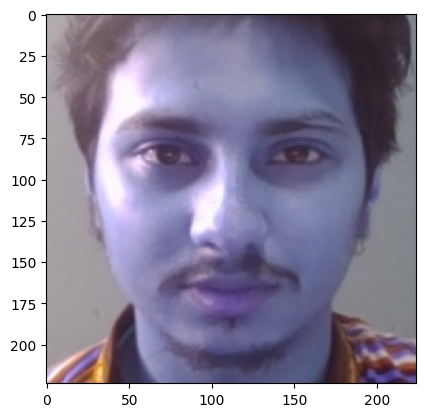

In [10]:
q = 80
import matplotlib.pyplot as plt
plt.imshow(x_test_images[q] , cmap = "gray")
result = model.predict(x_test_images)
if result[q]>=0.5:
    print('intruder')
else:
    print('allowed')

In [43]:
##realtime one
import cv2
face_classifier=cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml") #Note the change
video_capture = cv2.VideoCapture(0)
timer = 0
unknown = 0
wait_time = 20
while True:
    # Capture frame-by-frame
    ret, frames = video_capture.read()
    
    
    gray = cv2.cvtColor(frames, cv2.COLOR_BGR2GRAY)

    faces = face_classifier.detectMultiScale(
        gray,
        scaleFactor=1.1,
        minNeighbors=5,
        #minSize=(30, 30),
        #flags=cv2.CASCADE_SCALE_IMAGE
    )
    if len(faces) == 0:
        timer = 0
        unknown = 0
    
    # Draw a rectangle around the faces
    for (x, y, w, h) in faces:
        cv2.rectangle(frames, (x, y), (x+w, y+h), (0, 255, 0), 2)
        face = gray[y:y + h, x:x + w]
        face_resize = cv2.resize(face, (224, 224))
        color_channeled_image = cv2.cvtColor(face_resize, cv2.COLOR_GRAY2BGR)
        array=np.array(color_channeled_image)
        array=array/255
        img = array.reshape(1,224,224,3)
        result=model.predict(img)
        name='name'
        for j in range(100):
            for i in range(result.shape[1]):
                if result[0][i]<0.5:
                    name='Known'    
                else:
                    name='Unknown'
    
        timer +=1
        if name == 'Unknown':
            unknown +=1
        t=1

        value = str(((unknown)/wait_time)*100)+" %"    
                
        cv2.putText(img=frames, text=value, org=(50,50), fontFace=cv2.FONT_HERSHEY_TRIPLEX, fontScale=1, color=(255, 0, 0),thickness=1)            
        cv2.putText(img=frames, text=name, org=(x, y-20), fontFace=cv2.FONT_HERSHEY_TRIPLEX, fontScale=1, color=(255, 0, 0),thickness=1)
        print(result)
        print(f"timer = {timer},unknown = {unknown}")
        if timer>wait_time:
            timer = 0
            if unknown>=wait_time//2:
                playsound('beep.wav')
                t=0
    # Display the resulting frame
    cv2.imshow('Video', frames)

    if (cv2.waitKey(1) & 0xFF == ord('q')) or t==0:
        break
video_capture.release()
cv2.destroyAllWindows()

[[0.99353117]]
timer = 1,unknown = 1
[[0.02401551]]
timer = 2,unknown = 1
[[0.0121078]]
timer = 3,unknown = 1
[[0.01600447]]
timer = 4,unknown = 1
[[0.0177273]]
timer = 5,unknown = 1
[[0.00803176]]
timer = 6,unknown = 1
[[0.00292949]]
timer = 7,unknown = 1
[[0.00233903]]
timer = 8,unknown = 1
[[0.00247764]]
timer = 9,unknown = 1
[[0.00149773]]
timer = 10,unknown = 1
[[0.00229213]]
timer = 11,unknown = 1
[[0.00311091]]
timer = 12,unknown = 1
[[0.00674839]]
timer = 13,unknown = 1
[[0.02701838]]
timer = 14,unknown = 1
[[0.0854741]]
timer = 15,unknown = 1
[[0.03736383]]
timer = 16,unknown = 1
[[0.02179848]]
timer = 17,unknown = 1
[[0.02337797]]
timer = 18,unknown = 1
[[0.01893806]]
timer = 19,unknown = 1
[[0.01563862]]
timer = 20,unknown = 1
[[0.02281993]]
timer = 21,unknown = 1
[[0.03319345]]
timer = 1,unknown = 1
[[0.01539086]]
timer = 2,unknown = 1
[[0.02483956]]
timer = 3,unknown = 1
[[0.01730199]]
timer = 4,unknown = 1
[[0.01067755]]
timer = 5,unknown = 1
[[0.01648091]]
timer = 6,unkn